<a href="https://colab.research.google.com/github/SultanDaffaN/portfolio-sultan/blob/main/Tweets%20about%20Flood%20in%20Indonesia/Tweets_about_Flood_in_Indonesia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libraries**

In [ ]:
import numpy as np 
import pandas as pd 

import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import time 
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import plotly.express as px
import re
import random

# Natural Language Tool Kit 
import nltk  
nltk.download('stopwords') 
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **Reading Dataset**

In [ ]:
local_path = '/content/drive/MyDrive/Datathon/ristek-datathon'

In [ ]:
train = pd.read_csv(f'{local_path}/train.csv')
test = pd.read_csv(f'{local_path}/test.csv')

In [ ]:
train.head()

,created_at,id,user_id,user_name,url,text,media,label
0,2020-02-23 04:06:39+00:00,1231430140824973313,133931409,r0b1 sur1a (黄玉春),https://twitter.com/R0b1Sur1a/status/123143014...,Akhirnya sampai juga setelah menerobos banjir....,ERbrKgFU4AAnADb.jpg,0
1,2020-01-05 01:46:46+00:00,1213637932411580417,253063316,Beradaptasi di Era Pandemi ☀️,https://twitter.com/MarikaRahman_/status/12136...,"Kemekes RI, IDI Banten, IBI Banten dan PPNI Ba...",ENe1HUVUEAANLFT.jpg,0
2,2020-01-18 06:22:09+00:00,1218418277946396673,64318803,rywyu,https://twitter.com/rywyu/status/1218418277946...,Dikarenakan cikini rada2 banjir tdi pagi hingg...,EOiw80RU0AcJ4CI.jpg,0
3,2020-02-22 23:38:00+00:00,1231362534717837313,17383917,ICALIZERS,https://twitter.com/icalizers/status/123136253...,#sperma TT dikala warga jakarta sedang prihati...,ERatrt9UYAAtLMI.jpg,0
4,2019-12-17 10:54:31+00:00,1206890412574568449,3102973556,AN,https://twitter.com/lokbin103/status/120689041...,"KUIS!\n\nJakarta banjir parah hari ini, pertan...",EL-8Z-vUcAIiIlV.jpg,0


In [ ]:
test.head()

,created_at,id,user_id,user_name,url,text,media
0,2020-01-04 04:01:24+00:00,1213309429254250496,3278019654,Dinas LH Cakung,https://twitter.com/DinsihCakung/status/121330...,Giat pengangkutan sampah pasca banjir Rw 02 Ke...,ENaKfJ8VUAIUjb2.jpg
1,2020-01-12 03:14:24+00:00,1216196702647939072,1110443183379382272,Nunung Iskandar,https://twitter.com/IskandarNunung/status/1216...,Giat gotong-royong membersihkan jalan te kena ...,EODMcc8UEAA-7g_.jpg
2,2020-01-12 09:51:05+00:00,1216296533735309312,335900262,🇲🇾.N i e s a a .🇲🇾,https://twitter.com/Cik_AnaaNiesaa/status/1216...,"Terima kasih, tuan hamba. Tetap di sisi hamba ...",EOEnPtTUcAEsJXb.jpg
3,2020-03-02 07:48:31+00:00,1234385081482956800,3278019654,Dinas LH Cakung,https://twitter.com/DinsihCakung/status/123438...,pengambilan toilet portable tuntas pasca banji...,ESFqrKNU8AAip-t.jpg
4,2020-01-08 10:15:55+00:00,1214853229567041537,1186660471580921856,BEM STMIK WIDURI,https://twitter.com/bem_stmikwiduri/status/121...,[PRESS RELEASE]\nPra Kampus Widuri Peduli Benc...,ENwGelmUEAEa6Kq.jpg


# EDA

In [ ]:
train['label'].value_counts()

0    1192
1     326
Name: label, dtype: int64

In [ ]:
print('Dataset size:',train.shape)
print('Columns are:',train.columns)

Dataset size: (1518, 8)
Columns are: Index(['created_at', 'id', 'user_id', 'user_name', 'url', 'text', 'media',
       'label'],
      dtype='object')


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1518 entries, 0 to 1517
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   created_at  1518 non-null   object
 1   id          1518 non-null   int64 
 2   user_id     1518 non-null   int64 
 3   user_name   1518 non-null   object
 4   url         1518 non-null   object
 5   text        1518 non-null   object
 6   media       1518 non-null   object
 7   label       1518 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 95.0+ KB


Text(0, 0.5, '')

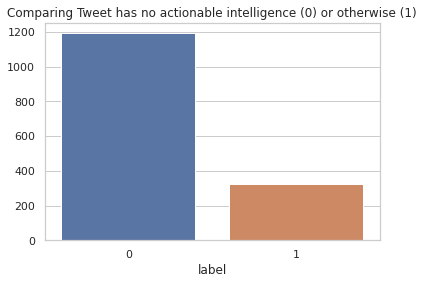

In [ ]:
sns.set_theme(style="whitegrid")
sns.countplot(x='label', data=train)
plt.title('Comparing Tweet has no actionable intelligence (0) or otherwise (1)')
plt.ylabel('')

In [ ]:
fig = px.pie(train, names='label', width=400, height=400)
fig.show()

# **Grouping the Data**

In [ ]:
# checking rows that labeled as 0 (non-intellegence)
labeled_0 = train.query(' label==0 ')
labeled_0

,created_at,id,user_id,user_name,url,text,media,label
0,2020-02-23 04:06:39+00:00,1231430140824973313,133931409,r0b1 sur1a (黄玉春),https://twitter.com/R0b1Sur1a/status/123143014...,Akhirnya sampai juga setelah menerobos banjir....,ERbrKgFU4AAnADb.jpg,0
1,2020-01-05 01:46:46+00:00,1213637932411580417,253063316,Beradaptasi di Era Pandemi ☀️,https://twitter.com/MarikaRahman_/status/12136...,"Kemekes RI, IDI Banten, IBI Banten dan PPNI Ba...",ENe1HUVUEAANLFT.jpg,0
2,2020-01-18 06:22:09+00:00,1218418277946396673,64318803,rywyu,https://twitter.com/rywyu/status/1218418277946...,Dikarenakan cikini rada2 banjir tdi pagi hingg...,EOiw80RU0AcJ4CI.jpg,0
3,2020-02-22 23:38:00+00:00,1231362534717837313,17383917,ICALIZERS,https://twitter.com/icalizers/status/123136253...,#sperma TT dikala warga jakarta sedang prihati...,ERatrt9UYAAtLMI.jpg,0
4,2019-12-17 10:54:31+00:00,1206890412574568449,3102973556,AN,https://twitter.com/lokbin103/status/120689041...,"KUIS!\n\nJakarta banjir parah hari ini, pertan...",EL-8Z-vUcAIiIlV.jpg,0
...,...,...,...,...,...,...,...,...
1512,2020-01-06 01:39:19+00:00,1213998448371847168,975986597605748736,Polsek Ngrampal,https://twitter.com/PNgrampal/status/121399844...,Banjir Bandang Brimob Jateng Bantu Perbaiki Tu...,ENj81O0UcAEGwTP.jpg,0
1513,2020-01-01 21:29:06+00:00,1212485925860626434,68304724,Fahira Idris DPD RI,https://twitter.com/fahiraidris/status/1212485...,Mohon doanya sahabat2ku untuk Musibah/ Bencana...,ENOdhJJU0AAA65K.jpg,0
1514,2020-01-02 05:19:53+00:00,1212604402969636869,315639357,arif jamali muis,https://twitter.com/arifjamalimuis/status/1212...,Tidak perlu berdebat siapa yang salah... mau p...,ENQJRCQVUAA-ytn.jpg,0
1515,2020-03-23 18:05:41+00:00,1242150538789019649,1187676813444575232,Bugha,https://twitter.com/Ifulmirwanda/status/124215...,"Banjir, karena tidak ada resapan. \nMundur, k...",ET0BTxXUUAILQMq.jpg,0


In [ ]:
print("The text: \n %s" % labeled_0.iloc[0, 5]+"\n")
print("The text: \n %s" % labeled_0.iloc[1, 5]+"\n")
print("The text: \n %s" % labeled_0.iloc[2, 5]+"\n")
print("The text: \n %s" % labeled_0.iloc[3, 5]+"\n")
print("The text: \n %s" % labeled_0.iloc[4, 5]+"\n")

The text: 
 Akhirnya sampai juga setelah menerobos banjir.. https://t.co/TqEUevU1rH

The text: 
 Kemekes RI, IDI Banten, IBI Banten dan PPNI Banten menuju daerah terisolasi putus akses banjir Lebak Banten 

@KemenkesRI 
@PBIDI https://t.co/ivZr5wLcxV

The text: 
 Dikarenakan cikini rada2 banjir tdi pagi hingga gk tau apa udh surut,
Ku memutuskan @gofoodindonesia membantu menyelamatkan gembel2 yg ada diperut ini,
Thnkyou buat bapak gofoodnya 😁👍 https://t.co/hjcJjm1M1k

The text: 
 #sperma TT dikala warga jakarta sedang prihatin #banjir 🤣🤣🤣
.
.
#banjirjakarta #BanjirJakarta2020 #pulomas #jakarta https://t.co/XhxmHasr7m

The text: 
 KUIS!

Jakarta banjir parah hari ini, pertanyaannya, siapakah yg akan disalahkan gubernur kali ini?

A. Ahok
B. Mentri PUPR
C. Kadis
D. Warga

Jawaban dikirimkan ke 

PO BOX 212
Dgn kode "ini bukan banjir tapi cobaan".

25 pemenang mendapatkan tiket gratis jalan2 di monas. https://t.co/SQED8TcW2b



In [ ]:
# checking rows that labeled as 1 (intellegence)
labeled_1 = train.query(' label==1 ')
labeled_1

,created_at,id,user_id,user_name,url,text,media,label
5,2020-02-24 01:23:55+00:00,1231751577372774400,1222102181270052869,Rizkalovianita,https://twitter.com/rizkalovianita/status/1231...,Banjir sudah 1 hari \n@RadioElshinta @jokowi @...,ERgPhLaWoAABqfJ.jpg,1
6,2020-02-25 01:44:48+00:00,1232119218474078209,841871718234877952,tomblok1806,https://twitter.com/PaulusSetiohut1/status/123...,Hmmmm banjir jilid 2. Belum 2 bulan th 2020 sd...,ERld4yzXUAcEyTm.jpg,1
9,2020-02-24 23:54:25+00:00,1232091442190811136,289218381,octadandy,https://twitter.com/octadandy/status/123209144...,06.51 Pagi Hari (25022020) - Kondisi sisa rint...,ERlElPeUUAAkJ0J.jpg,1
18,2020-02-27 11:03:49+00:00,1232984677960388608,1014705544580354049,Moeslema Wached,https://twitter.com/IMuslimah77/status/1232984...,Lihat sawah yg kena banjir https://t.co/xdCkRY...,ERxw-_XUYAEu-hk.jpg,1
24,2020-02-24 20:58:52+00:00,1232047263792300032,2359192436,Michel Vernandez,https://twitter.com/MichVernandez/status/12320...,#Banjir \nLokasi : Kelurahan Halim Perdana Kus...,ERkccdHUwAE9Th9.jpg,1
...,...,...,...,...,...,...,...,...
1475,2020-01-05 08:34:09+00:00,1213740456879640583,1146481353342373888,Me9,https://twitter.com/Me9Ten/status/121374045687...,Banjir https://t.co/SQ1Z64a7T8,ENgSfmAUwAAOURn.jpg,1
1490,2020-02-23 01:07:58+00:00,1231385173440094209,76647722,TMC Polda Metro Jaya,https://twitter.com/TMCPoldaMetro/status/12313...,08:05 #Banjir 20-30 cm di wilayah Semper #Jaka...,ERbCQsmVUAEq7GC.jpg,1
1503,2020-02-24 22:52:58+00:00,1232075977385136128,1229085102174375936,Hilman17,https://twitter.com/Hilman179/status/123207597...,Mau berangkat kerja malah ujan terus\n#banjir ...,ERk2j7rUEAE9st0.jpg,1
1505,2020-02-25 01:11:21+00:00,1232110804570296320,346303384,BNPB Indonesia,https://twitter.com/BNPB_Indonesia/status/1232...,Gerbang Tol Cempaka Putih tidaka dapat dilewat...,ERlWN3rU8AAsbr1.jpg,1


In [ ]:
print("The text: \n %s" % labeled_1.iloc[5, 5]+"\n")
print("The text: \n %s" % labeled_1.iloc[6, 5]+"\n")
print("The text: \n %s" % labeled_1.iloc[9, 5]+"\n")
print("The text: \n %s" % labeled_1.iloc[18, 5]+"\n")
print("The text: \n %s" % labeled_1.iloc[24, 5]+"\n")

The text: 
 Terakhir 17 Tahun yg lalu di kayumas pulogadung kebanjiran... bukannya kemajuan malah makin PARAH banjirnya... #jakarta #KompasUpdate #happynewyear2020 #Jokowi #AniesBaswedan #basarnas #banjir #kebanjiran https://t.co/qfC9CBMit6

The text: 
 #banjir depan bebek  BKB jalan Satrio https://t.co/j7zO881Ti5

The text: 
 listrik barusan banget nyala, terus mati lagi... banjir dalem rumah udah selutut dan masih terus naik https://t.co/wjnYnAlDpZ

The text: 
 Tambun Bekasi Cok #banjir https://t.co/PcirWCLh1H

The text: 
 Depan kantor, ga bisa ke kantor dan akhirnya nerjang banjir https://t.co/pC22cmyImT



# **Data Training**

## **Processing Text Data**

In [ ]:
training_text = train[['id', 'text', 'label']]
training_text

,id,text,label
0,1231430140824973313,Akhirnya sampai juga setelah menerobos banjir....,0
1,1213637932411580417,"Kemekes RI, IDI Banten, IBI Banten dan PPNI Ba...",0
2,1218418277946396673,Dikarenakan cikini rada2 banjir tdi pagi hingg...,0
3,1231362534717837313,#sperma TT dikala warga jakarta sedang prihati...,0
4,1206890412574568449,"KUIS!\n\nJakarta banjir parah hari ini, pertan...",0
...,...,...,...
1513,1212485925860626434,Mohon doanya sahabat2ku untuk Musibah/ Bencana...,0
1514,1212604402969636869,Tidak perlu berdebat siapa yang salah... mau p...,0
1515,1242150538789019649,"Banjir, karena tidak ada resapan. \nMundur, k...",0
1516,1232074747707441152,"#banjir jam 05.45 diluar rumah 20-30 cm, didlm...",1


In [ ]:
# print the text
training_text['text'].iloc[4]

'KUIS!\n\nJakarta banjir parah hari ini, pertanyaannya, siapakah yg akan disalahkan gubernur kali ini?\n\nA. Ahok\nB. Mentri PUPR\nC. Kadis\nD. Warga\n\nJawaban dikirimkan ke \n\nPO BOX 212\nDgn kode "ini bukan banjir tapi cobaan".\n\n25 pemenang mendapatkan tiket gratis jalan2 di monas. https://t.co/SQED8TcW2b'

### **Removing the URl's**

In [ ]:
# Removing the last word
def remove_urls(texts):
  return re.sub('https?://\S+|www\.\S+', '', texts)

training_text['text'] = training_text['text'].apply(lambda x: remove_urls(x))

<ipython-input-642-591b7a637d08>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# print the text
training_text['text'].iloc[4]

'KUIS!\n\nJakarta banjir parah hari ini, pertanyaannya, siapakah yg akan disalahkan gubernur kali ini?\n\nA. Ahok\nB. Mentri PUPR\nC. Kadis\nD. Warga\n\nJawaban dikirimkan ke \n\nPO BOX 212\nDgn kode "ini bukan banjir tapi cobaan".\n\n25 pemenang mendapatkan tiket gratis jalan2 di monas. '

### **Lower Casing**

In [ ]:
def lower_casing(text):
  return text.lower()

training_text['text'] = training_text['text'].apply(lambda x: lower_casing(x))

<ipython-input-644-8514aea92de0>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# print the text
training_text['text'].iloc[4]

'kuis!\n\njakarta banjir parah hari ini, pertanyaannya, siapakah yg akan disalahkan gubernur kali ini?\n\na. ahok\nb. mentri pupr\nc. kadis\nd. warga\n\njawaban dikirimkan ke \n\npo box 212\ndgn kode "ini bukan banjir tapi cobaan".\n\n25 pemenang mendapatkan tiket gratis jalan2 di monas. '

### **Remove Punctuation**

In [ ]:
import re
import string

PUNCTUATIONS = string.punctuation

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', PUNCTUATIONS))

training_text['text'] = training_text['text'].apply(lambda x: remove_punctuation(x))

<ipython-input-646-f6c864204868>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# print the text
training_text['text'].iloc[4]

'kuis\n\njakarta banjir parah hari ini pertanyaannya siapakah yg akan disalahkan gubernur kali ini\n\na ahok\nb mentri pupr\nc kadis\nd warga\n\njawaban dikirimkan ke \n\npo box 212\ndgn kode ini bukan banjir tapi cobaan\n\n25 pemenang mendapatkan tiket gratis jalan2 di monas '

### **Extra Whitespaces**

In [ ]:
def remove_extra_whitespaces(text):
    return " ".join(text.split())

training_text['text'] = training_text['text'].apply(lambda x: remove_extra_whitespaces(x))

<ipython-input-648-c29655321ade>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# print the text
training_text['text'].iloc[4]

'kuis jakarta banjir parah hari ini pertanyaannya siapakah yg akan disalahkan gubernur kali ini a ahok b mentri pupr c kadis d warga jawaban dikirimkan ke po box 212 dgn kode ini bukan banjir tapi cobaan 25 pemenang mendapatkan tiket gratis jalan2 di monas'

### **Remove Stopwords**

In [ ]:
from spacy.lang.id.stop_words import STOP_WORDS

def remove_stopwords(text):
    text = re.sub('[^a-zA-Z]', ' ', text)  
    text = text.split()  
    text = [word for word in text if word not in STOP_WORDS]
    text = ' '.join(text)
    
    return text

training_text['text'] = training_text['text'].apply(lambda x: remove_stopwords(x))

<ipython-input-650-142860a776ed>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# print the text
training_text['text'].iloc[4]

'kuis jakarta banjir parah pertanyaannya yg disalahkan gubernur kali a ahok b mentri pupr c kadis d warga dikirimkan po box dgn kode banjir cobaan pemenang tiket gratis jalan monas'

### **Word Counter**

In [ ]:
from collections import Counter

# How many unique words have this text
def counter_word (text):
    count = Counter()
    for i in text.values:
        for word in i.split():
            count[word] += 1
    return count

In [ ]:
counter = counter_word(training_text['text'])
print("There are %d unique words" % (len(counter)))

# show top 10 words
list(sorted(counter.items(), key=lambda x:x[1], reverse=True))[:10]

There are 7171 unique words


[('banjir', 1787),
 ('yg', 242),
 ('jakarta', 215),
 ('korban', 157),
 ('air', 143),
 ('rumah', 135),
 ('hujan', 119),
 ('warga', 114),
 ('bencana', 107),
 ('banjirjakarta', 104)]

In [ ]:
# Get the mean length of each sentences
length = np.mean([len(x) for x in training_text.text])
length

109.0171277997365

## **Splitting Dataset**

In [ ]:
# Stratified splitting (for testing & validation set)
labeled_0 = training_text.query(' label==0 ')
labeled_1 = training_text.query(' label==1 ')
print(labeled_0.shape)
print(labeled_1.shape)

(1192, 3)
(326, 3)


In [ ]:
training_size = round(labeled_0.shape[0] * 80/100)
training_labeled_0 = labeled_0[0:training_size]
validation_labeled_0 = labeled_0[training_size:]

training_size = round(labeled_1.shape[0] * 80/100)
training_labeled_1 = labeled_1[0:training_size]
validation_labeled_1 = labeled_1[training_size:]

In [ ]:
training_data = pd.concat([training_labeled_0, training_labeled_1])
training_data

,id,text,label
0,1231430140824973313,menerobos banjir,0
1,1213637932411580417,kemekes ri idi banten ibi banten ppni banten d...,0
2,1218418277946396673,cikini rada banjir tdi pagi gk tau udh surut k...,0
3,1231362534717837313,sperma tt dikala warga jakarta prihatin banjir...,0
4,1206890412574568449,kuis jakarta banjir parah pertanyaannya yg dis...,0
...,...,...,...
1197,1232107114841034753,banjir jalan kodamar bypass flyover kelapa gad...,1
1207,1212188311357255681,me semangat biarlah air banjir bantu,1
1208,1231576560320180225,kawasan menteng banjir tmc polda banjir cm jl ...,1
1212,1232189028616687616,first time bgt nih ngerasain namanya banjir ba...,1


In [ ]:
validation_data = pd.concat([validation_labeled_0, validation_labeled_1])
validation_data

,id,text,label
1214,1213715102542680064,bpk menteri desa halimiskandarnu sdh meginstru...,0
1215,1217658100590604289,sebaran wilayah banjir petabencana dipakai bpp...,0
1216,1212220761005420545,katsoka korianka jalan tol bergelombang disala...,0
1217,1212687107086376960,yuk membantu korban banjir,0
1218,1218026615105437697,gara anies nih hello surabayapiye kabare semog...,0
...,...,...,...
1475,1213740456879640583,banjir,1
1490,1231385173440094209,banjir cm wilayah semper jakarta utara sindyanast,1
1503,1232075977385136128,berangkat kerja ujan banjir,1
1505,1232110804570296320,gerbang tol cempaka putih tidaka dilewati kend...,1


In [ ]:
# Shuffling dataset
training_data = training_data.sample(frac=1)
validation_data = validation_data.sample(frac=1)
print(training_data.shape)
print(validation_data.shape)

(1215, 3)
(303, 3)


## **Tokenizing Texts**

In [ ]:
training_sentences = training_data.text
training_labels = training_data.label

validation_sentences = validation_data.text
validation_labels = validation_data.label

In [ ]:
# Setting the parameters use for embedding
vocab_size = len(counter)
max_length = 95
trunc_type='post'
padding_type='post'
oov_token = "<XXX>"
embedding_dim = 64
lstm_dim = 32

In [ ]:
# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)

# Generate the word index dictionary
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

# Generate and pad the training sequences
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Generate and pad the testing sequences
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Convert the labels lists into numpy arrays
training_labels = np.array(training_labels)
validation_labels = np.array(validation_labels)

In [ ]:
print('training padded:', len(training_padded))
print('testing padded:', len(validation_padded))
print()
print('training labels:', len(training_labels))
print('validation labels:', len(validation_labels))

training padded: 1215
testing padded: 303

training labels: 1215
validation labels: 303


# **Build and Compile Model**

In [ ]:
# Create the LSTM model
text_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

# Compile the model
text_model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
text_model.summary()

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_41 (Embedding)    (None, 95, 64)            458944    
                                                                 
 bidirectional_41 (Bidirecti  (None, 64)               24832     
 onal)                                                           
                                                                 
 dense_123 (Dense)           (None, 64)                4160      
                                                                 
 dense_124 (Dense)           (None, 32)                2080      
                                                                 
 dense_125 (Dense)           (None, 2)                 66        
                                                                 
Total params: 490,082
Trainable params: 490,082
Non-trainable params: 0
_______________________________________________

In [ ]:
# Setting the training parameters
NUM_EPOCHS = 30
earlystopping = tf.keras.callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)

In [ ]:
# Train the model
history = text_model.fit(training_padded, training_labels, epochs=NUM_EPOCHS, validation_data=(validation_padded, validation_labels), callbacks=[earlystopping])

Epoch 1/30
38/38 [==============================] - 10s 158ms/step - loss: 0.5633 - accuracy: 0.7819 - val_loss: 0.5226 - val_accuracy: 0.7855
Epoch 2/30
38/38 [==============================] - 3s 72ms/step - loss: 0.4201 - accuracy: 0.8041 - val_loss: 0.4358 - val_accuracy: 0.8152
Epoch 3/30
38/38 [==============================] - 3s 77ms/step - loss: 0.1764 - accuracy: 0.9366 - val_loss: 0.4303 - val_accuracy: 0.8152
Epoch 4/30
38/38 [==============================] - 2s 50ms/step - loss: 0.0643 - accuracy: 0.9819 - val_loss: 0.5317 - val_accuracy: 0.8317
Epoch 5/30
38/38 [==============================] - 2s 43ms/step - loss: 0.0311 - accuracy: 0.9852 - val_loss: 0.6526 - val_accuracy: 0.8416
Epoch 6/30
38/38 [==============================] - 3s 75ms/step - loss: 0.0225 - accuracy: 0.9934 - val_loss: 0.6076 - val_accuracy: 0.8482
Epoch 7/30
38/38 [==============================] - 3s 63ms/step - loss: 0.0158 - accuracy: 0.9942 - val_loss: 0.6828 - val_accuracy: 0.8482
Epoch 8/30


In [ ]:
import matplotlib.pyplot as plt

# Plot Utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

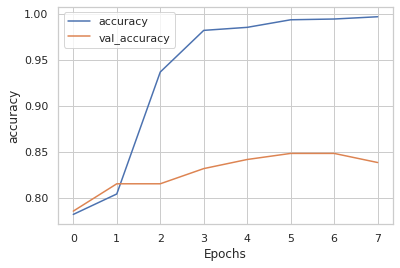

In [ ]:
# Plot the accuracy history
plot_graphs(history, 'accuracy')

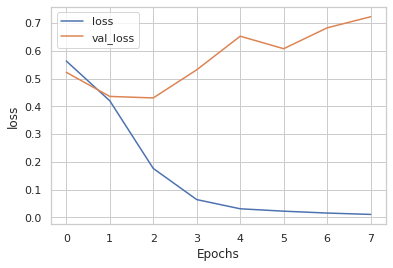

In [ ]:
# Plot the loss history
plot_graphs(history, 'loss')

# **Model Evaluation**

In [ ]:
predictions = text_model.predict(validation_padded)
predictions_classes = np.argmax(predictions,axis=1)
predictions_classes

10/10 [==============================] - 1s 5ms/step


array([0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

# Showing Confusion Matrix
def plot_cm(y_true, y_pred, title, figsize=(5,4)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

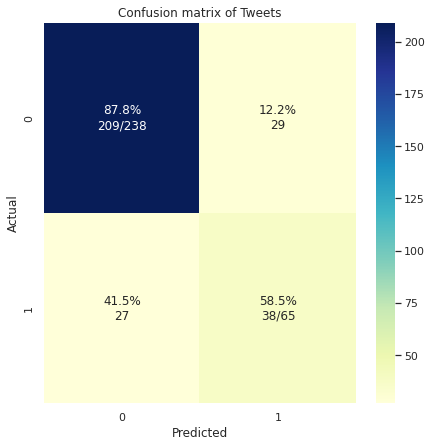

In [ ]:
# Showing Confusion Matrix
plot_cm(validation_labels,predictions_classes, 'Confusion matrix of Tweets', figsize=(7,7))

In [ ]:
print(classification_report(validation_labels, predictions_classes))

              precision    recall  f1-score   support

           0       0.89      0.88      0.88       238
           1       0.57      0.58      0.58        65

    accuracy                           0.82       303
   macro avg       0.73      0.73      0.73       303
weighted avg       0.82      0.82      0.82       303



In [ ]:
from sklearn import metrics

metrics.f1_score(validation_labels, predictions_classes, average='weighted')

0.816191745756854

# **Data Testing**

## **Processing Text Data**

In [ ]:
display(test)

,created_at,id,user_id,user_name,url,text,media
0,2020-01-04 04:01:24+00:00,1213309429254250496,3278019654,Dinas LH Cakung,https://twitter.com/DinsihCakung/status/121330...,Giat pengangkutan sampah pasca banjir Rw 02 Ke...,ENaKfJ8VUAIUjb2.jpg
1,2020-01-12 03:14:24+00:00,1216196702647939072,1110443183379382272,Nunung Iskandar,https://twitter.com/IskandarNunung/status/1216...,Giat gotong-royong membersihkan jalan te kena ...,EODMcc8UEAA-7g_.jpg
2,2020-01-12 09:51:05+00:00,1216296533735309312,335900262,🇲🇾.N i e s a a .🇲🇾,https://twitter.com/Cik_AnaaNiesaa/status/1216...,"Terima kasih, tuan hamba. Tetap di sisi hamba ...",EOEnPtTUcAEsJXb.jpg
3,2020-03-02 07:48:31+00:00,1234385081482956800,3278019654,Dinas LH Cakung,https://twitter.com/DinsihCakung/status/123438...,pengambilan toilet portable tuntas pasca banji...,ESFqrKNU8AAip-t.jpg
4,2020-01-08 10:15:55+00:00,1214853229567041537,1186660471580921856,BEM STMIK WIDURI,https://twitter.com/bem_stmikwiduri/status/121...,[PRESS RELEASE]\nPra Kampus Widuri Peduli Benc...,ENwGelmUEAEa6Kq.jpg
...,...,...,...,...,...,...,...
1006,2020-01-01 13:55:32+00:00,1212371781350084608,53922892,Cyril Raoul Hakim,https://twitter.com/chicohakim/status/12123717...,Pengendalian Banjir memang identik dengan ‘ker...,ENM1siHUYAElpR_.jpg
1007,2020-02-24 22:49:41+00:00,1232075152042541056,3169526630,yaya,https://twitter.com/Arnia_Adnarnia/status/1232...,Buaran jakarta timur bisa buat berenang.\nLebi...,ERk1zdoUEAAa3_j.jpg
1008,2020-01-04 04:25:47+00:00,1213315563595845633,1182146749629992960,rizkihidayat,https://twitter.com/rizkihi85048374/status/121...,"Banjir d prov. Riau,,Polisi Siaga,, \n#RiauPed...",ENaQCGvUEAEbXUW.jpg
1009,2020-01-03 05:35:44+00:00,1212970781610663936,50899901,(◕ᴗ◕✿),https://twitter.com/sher0690/status/1212970781...,ada kolam di alsut kmrn kena banjir 😳 https://...,ENVWe93VUAE_AGg.jpg


In [ ]:
testing_text = test[['id', 'text']]
testing_text

,id,text
0,1213309429254250496,Giat pengangkutan sampah pasca banjir Rw 02 Ke...
1,1216196702647939072,Giat gotong-royong membersihkan jalan te kena ...
2,1216296533735309312,"Terima kasih, tuan hamba. Tetap di sisi hamba ..."
3,1234385081482956800,pengambilan toilet portable tuntas pasca banji...
4,1214853229567041537,[PRESS RELEASE]\nPra Kampus Widuri Peduli Benc...
...,...,...
1006,1212371781350084608,Pengendalian Banjir memang identik dengan ‘ker...
1007,1232075152042541056,Buaran jakarta timur bisa buat berenang.\nLebi...
1008,1213315563595845633,"Banjir d prov. Riau,,Polisi Siaga,, \n#RiauPed..."
1009,1212970781610663936,ada kolam di alsut kmrn kena banjir 😳 https://...


In [ ]:
testing_text['text'] = testing_text['text'].apply(lambda x: remove_urls(x))
testing_text['text'] = testing_text['text'].apply(lambda x: lower_casing(x))
testing_text['text'] = testing_text['text'].apply(lambda x: remove_punctuation(x))
testing_text['text'] = testing_text['text'].apply(lambda x: remove_extra_whitespaces(x))
testing_text['text'] = testing_text['text'].apply(lambda x: remove_stopwords(x))

<ipython-input-734-16d16edef249>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-734-16d16edef249>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-734-16d16edef249>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-734-16d

In [ ]:
testing_text['text'].iloc[0]

'giat pengangkutan sampah pasca banjir rw kelcakung timur keccakungsabtu januari aniesbaswedan herwansyah yogiikhwan dinaslhdki setiomargono ppdlksudinlhjaktim pasukanorangedlh dinaslhdki jktbebassampah gogreen welovejakarta bersihbisakok'

## **Tokenizing Texts**

In [ ]:
# Generate and pad the testing sequences
testing_sequences = tokenizer.texts_to_sequences(testing_text['text'])
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# **Predicting Data Testing**

In [ ]:
predictions = text_model.predict(testing_padded)

32/32 [==============================] - 0s 7ms/step


In [ ]:
predictions_classes = np.argmax(predictions, axis=1)
with np.printoptions(threshold=np.inf):
    print(predictions_classes)

[0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 1
 0 0 0 0 1 0 0 1 0 0 0 1 1 1 1 0 0 1 1 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0
 0 0 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 1 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 1 0 0 0 0 1 0 0 0 1 0 0 0 0
 1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1
 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0
 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 1 0 1 0
 1 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0
 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 

# **Converting Result to DataFrame Submission**

In [ ]:
result_df = pd.DataFrame({'id': test['id'],
                       'label': predictions_classes,
                       })

In [ ]:
result_df

,id,label
0,1213309429254250496,0
1,1216196702647939072,0
2,1216296533735309312,0
3,1234385081482956800,0
4,1214853229567041537,0
...,...,...
1006,1212371781350084608,0
1007,1232075152042541056,1
1008,1213315563595845633,0
1009,1212970781610663936,0


In [ ]:
result_df.label.value_counts()

0    809
1    202
Name: label, dtype: int64

In [ ]:
from google.colab import files
result_df.to_csv("final_submission_nlp.csv", index=False, header=True)
files.download('final_submission_nlp.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>